In [1]:
import networkx as nx 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import math 

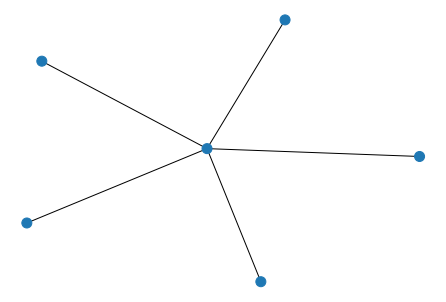

In [196]:
G = nx.star_graph(5)


B_param_init = lambda arr: {list(G.nodes)[i]: arr[i] for i in range(len(list(G.nodes)))}
h = np.zeros(len(list(G.nodes)))

B_init = B_param_init(h)


nx.set_node_attributes(G,B_init, "exp_field")
nx.draw(G,node_size=(h+1)*100)




In [248]:
from scipy.optimize import fixed_point


def projection_simplex_pivot(v, z=1, random_state=None):
    rs = np.random.RandomState(random_state)
    n_features = len(v)
    U = np.arange(n_features)
    s = 0
    rho = 0
    while len(U) > 0:
        G = []
        L = []
        k = U[rs.randint(0, len(U))]
        ds = v[k]
        for j in U:
            if v[j] >= v[k]:
                if j != k:
                    ds += v[j]
                    G.append(j)
            elif v[j] < v[k]:
                L.append(j)
        drho = len(G) + 1
        if s + ds - (rho + drho) * v[k] < z:
            s += ds
            rho += drho
            U = L
        else:
            U = G
    theta = (s - z) / float(rho)
    return np.maximum(v - theta, 0)


def projection_simplex_sort(v, z=1):
    n_features = v.shape[0]
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(n_features) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    w = np.maximum(v - theta, 0)
    return w

        
class mf_ising_system:

    def __init__(self,graph,background_field,fixed_point_iter=1000,init_mag=None,fp_tol_fac=10-8,iim_iter=1000,step_size=1.0,
        iim_tol_fac=1e-5):
        self.adj_matrix = nx.to_numpy_matrix(graph)
        self.graph_size = len(graph.nodes.keys())
        self.background_field = background_field
        self.fixed_point_iter=fixed_point_iter
        self.iim_iter = iim_iter
        self.fp_tol_fac=fp_tol_fac
        self.iim_tol_fac=iim_tol_fac
        self.step_size=step_size
        if all(init_mag)==None:
            self.init_mag=np.ones(self.graph_size)
        else:
            self.init_mag = init_mag 
            
        
    def single_mag(self,i,m,beta,field):
        spin_field = np.dot(self.adj_matrix[i],m)
        return math.tanh(beta*(spin_field+field[i]))
    
    def magnetisation(self,beta,mag,field):
        m_old = mag
        m_new = np.zeros(len(m_old))
        for i in range(system.graph_size):
            m_new[i]=system.single_mag(i,m_old,beta,field)
        return m_new

    
    def fixedPointAitken(self,beta,mag,field):      
        # Numerical Analysis Richard L.Burden 9th Edition, p. 105
        
        for it in range(self.fixed_point_iter):                 
            mag1=self.magnetisation(beta,mag,field)
            mag2=self.magnetisation(beta,mag1,field)   

            if abs(np.sum(mag1-mag))<self.fp_tol_fac: break
            mag = mag - (mag1-mag)**2/(mag+mag2-2*mag1) 
        return mag
    
    def mag_grad(self,beta,mag):
        # Mean Field Susceptibility;
        
        if all([math.isclose(i,j,abs_tol=1e-4) for i,j in zip(mag,np.ones(len(mag)))]):
            gradient = np.zeros(len(mag))
        else:
            D=np.sum([(1-mag[i]**2) for i in range(self.graph_size)]) # equals to 0 if all m's are 1 or close to 1
            susc_matrix = beta*np.linalg.inv(np.identity(self.graph_size)-beta*D*self.adj_matrix)*D
            gradient = np.sum(susc_matrix,axis=0)
                
        return gradient
    
    def MF_IIM(self,field_budget,beta,init_control_field='uniform'):
              
        if init_control_field=='uniform':
            control_field = (field_budget/self.graph_size)*np.ones(self.graph_size)
        else:
            control_field = init_control_field

        # initial magnetisation as influenced by initial budget spread
        # note: different from init_mag which denotes initial magnetisation *without* the external field      
        tot_field = np.array(self.background_field+control_field)

        control_field_history=[]
        control_field_history.append(control_field)
        mag_i = self.fixedPointAitken(beta,mag_0,tot_field)
        for it in range(self.iim_iter):
            mag_i_grad = self.mag_grad(beta,mag_i).A1
            control_field = control_field_history[it]

            control_field_update = (control_field + self.step_size*mag_i_grad)

            control_field_new = projection_simplex_pivot(control_field_update.T,z=field_budget)

            
            tot_field = np.array(self.background_field+control_field_new)
            mag_ii = self.fixedPointAitken(beta,mag_i,tot_field)


            if np.abs(np.sum(mag_ii-mag_i)) <= self.iim_tol_fac:
                break
            control_field_history.append(control_field_new)
            mag_i=mag_ii
        if it==self.iim_iter:
            print('Failed to converge after {} iterations'.format(self.iim_iter))
            
        return control_field,it
            
        
                
budget=5.0
beta=0.24
init_mag=np.array([2.0,1.0,0.0,3.4,3.9,0.0])


system = mf_ising_system(G,h,init_mag=init_mag)
    
x=system.MF_IIM(budget,beta)
print(x)


(array([0.83333333, 0.83333333, 0.83333333, 0.83333333, 0.83333333,
       0.83333333]), 0)


In [ ]:

control_field = (budget/system.graph_size)*np.ones(system.graph_size)
bf = system.background_field+control_field
mag0 = system.fixedPointAitken(beta,system.init_mag,bf)
mag1=system.fixedPointAitken(beta,mag_0,bf)
print(mag1)
mag1_g = system.mag_grad(beta,mag1)

control_field_update = control_field + system.step_size*mag1_g

control_field_new = projection_simplex_sort(control_field_update.T,z=budget).A1

bf = system.background_field+control_field_new
mag2 = system.fixedPointAitken(beta,mag1,bf)
print(mag2)

In [108]:
 
def func(x):
    try:
        return 1/3*x**2+2/3
    except Exception as e:
        print(x)
        
def FixedPointAitken(func,p0,tolerance):                     
    for it in range(system.fixed_point_iter):                 
        p1=func(p0)
        p2=func(p1)   

        if abs(np.sum(p1-p0))<tolerance: break
        p0 = p0 - (p1-p0)**2/(p0+p2-2*p1) 
    return p0
        

z=FixedPointAitken(func,2.1,1e-10)
print(z)

1.9999999999999991


In [23]:
system.update(beta)

array([0.66403677, 0.19737532, 0.19737532, 0.19737532, 0.19737532])

In [39]:
J[0]

matrix([[0., 1., 1., 1., 1.]])

5